# Task 2 - MNIST Dataset Neural Network

In [1]:
# Import libraries
import numpy as np
from keras.datasets import mnist
from matplotlib import pyplot as plt

# Set random seed for reproducibility
np.random.seed(46853)

In [2]:
# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Preprocess the data
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# Convert the labels to categorical variables
y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

# Initialize the weights and biases
weights = {}
biases = {}

# Initialize the input layer weights and biases
weights['w1'] = np.random.randn(784, 512)
biases['b1'] = np.zeros((1, 512))

# Initialize the hidden layer weights and biases
weights['w2'] = np.random.randn(512, 512)
biases['b2'] = np.zeros((1, 512))

# Initialize the output layer weights and biases
weights['w3'] = np.random.randn(512, 10)
biases['b3'] = np.zeros((1, 10))

# Set the learning rate
learning_rate = 0.01

# Set the dropout rate
dropout_rate = 0.5

# Set the number of epochs
num_epochs = 100

# Set the batch size
batch_size = 8

# Set the number of batches
num_batches = X_train.shape[0] // batch_size

# Create arrays for the accuracy and loss measurements
mean_accuracies = []
mean_losses = []

In [3]:
# Define sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Define the SGD optimiser
def sgd_optimiser(grad_w1, grad_b1, grad_w2, grad_b2, grad_w3, grad_b3, learning_rate, weights, biases):
    weights['w1'] -= learning_rate * grad_w1
    biases['b1'] -= learning_rate * grad_b1
    weights['w2'] -= learning_rate * grad_w2
    biases['b2'] -= learning_rate * grad_b2
    weights['w3'] -= learning_rate * grad_w3
    biases['b3'] -= learning_rate * grad_b3

# Calculate the cross-entropy loss
def cross_entropy_loss(y, y_pred, smoothing=1e-8):
    # Add the smoothing factor to the prediction to avoid division by zero
    y_pred = y_pred + smoothing
    return -np.sum(y * np.log(y_pred))

In [4]:
# Define the test for the sigmoid function
def test_sigmoid_layer():
    # Test 1: Check that the sigmoid function returns the expected output
    z = np.array([[-2, -1, 0, 1, 2]])
    expected_output = np.array([[0.119203, 0.268941, 0.5, 0.731059, 0.880797]])
    output = sigmoid(z)
    assert np.allclose(output, expected_output), f"Expected {expected_output}, but got {output}"

    # Test 2: Check that the sigmoid function is stable when the input is very large
    z = np.array([[100, 1000, 10000]])
    expected_output = np.array([[1, 1, 1]])
    output = sigmoid(z)
    assert np.allclose(output, expected_output), f"Expected {expected_output}, but got {output}"

# Run the test suite
test_sigmoid_layer()

In [5]:
# Train the model
for epoch in range(num_epochs):
    # Shuffle the training data
    permutation = np.random.permutation(X_train.shape[0])
    X_train = X_train[permutation]
    y_train = y_train[permutation]

    # Loop over the batches
    for batch in range(num_batches):
        # Get the batch data
        start = batch * batch_size
        end = start + batch_size
        X_batch = X_train[start:end]
        y_batch = y_train[start:end]

        # Forward propagation
        z1 = X_batch.dot(weights['w1']) + biases['b1']
        a1 = sigmoid(z1)

        # Implement dropout
        mask = np.random.binomial(1, 1 - dropout_rate, size=a1.shape)
        a1 *= mask

        z2 = a1.dot(weights['w2']) + biases['b2']
        a2 = sigmoid(z2)

        # Implement dropout
        mask = np.random.binomial(1, 1 - dropout_rate, size=a2.shape)
        a2 *= mask

        z3 = a2.dot(weights['w3']) + biases['b3']
        a3 = sigmoid(z3)

        # Calculate the loss
        loss = cross_entropy_loss(y_batch, a3)

        # Backward propagation
        grad_z3 = a3 - y_batch
        grad_w3 = a2.T.dot(grad_z3) / batch_size
        grad_b3 = np.sum(grad_z3, axis=0, keepdims=True) / batch_size

        grad_a2 = grad_z3.dot(weights['w3'].T)

        # Scale the gradients by the inverse of the dropout rate
        grad_a2 *= 1.0 / (1.0 - dropout_rate)

        grad_z2 = grad_a2 * sigmoid(z2) * (1 - sigmoid(z2))
        grad_w2 = a1.T.dot(grad_z2) / batch_size
        grad_b2 = np.sum(grad_z2, axis=0, keepdims=True) / batch_size

        grad_a1 = grad_z2.dot(weights['w2'].T)

        # Scale the gradients by the inverse of the dropout rate
        grad_a1 *= 1.0 / (1.0 - dropout_rate)

        grad_z1 = grad_a1 * sigmoid(z1) * (1 - sigmoid(z1))
        grad_w1 = X_batch.T.dot(grad_z1) / batch_size
        grad_b1 = np.sum(grad_z1, axis=0, keepdims=True) / batch_size

        # Update the weights and biases
        sgd_optimiser(grad_w1, grad_b1, grad_w2, grad_b2, grad_w3, grad_b3, learning_rate, weights, biases)

        # print statistics
        if batch % 1000 == 999:  # print every 2000 mini-batches
            print("Batch: " + str(batch))
            running_loss = 0.0

    print("Epochs:", epoch + 1)

    # Calculate the accuracy on the test set
    z1 = X_test.dot(weights['w1']) + biases['b1']
    a1 = sigmoid(z1)
    z2 = a1.dot(weights['w2']) + biases['b2']
    a2 = np.maximum(z2, 0)  # ReLU activation function
    z3 = a2.dot(weights['w3']) + biases['b3']

    # Shift the input values down to prevent overflow
    z3_shift = z3 - np.max(z3, axis=1, keepdims=True)

    # Calculate the softmax activations
    a3 = np.exp(z3_shift) / np.sum(np.exp(z3_shift), axis=1, keepdims=True)

    loss = cross_entropy_loss(y_test, a3)
    mean_loss = loss / len(y_test)
    mean_losses.append(mean_loss)

    # Calculate the predictions
    predictions = a3.argmax(axis=1)

    # Calculate the number of correct predictions
    num_correct = (predictions == y_test.argmax(axis=1)).sum()

    # Calculate the mean accuracy
    accuracy = num_correct / len(predictions)

    # Store the accuracy in a list
    mean_accuracies.append(accuracy)

    # Print the accuracy
    print(f'Accuracy: {accuracy:.4f}')

Batch: 999
Batch: 1999
Batch: 2999
Batch: 3999
Batch: 4999
Batch: 5999
Batch: 6999
Epochs: 1
Accuracy: 0.8565
Batch: 999
Batch: 1999
Batch: 2999
Batch: 3999
Batch: 4999
Batch: 5999
Batch: 6999
Epochs: 2
Accuracy: 0.8977
Batch: 999
Batch: 1999
Batch: 2999
Batch: 3999
Batch: 4999
Batch: 5999
Batch: 6999
Epochs: 3
Accuracy: 0.9107
Batch: 999
Batch: 1999
Batch: 2999
Batch: 3999
Batch: 4999
Batch: 5999
Batch: 6999
Epochs: 4
Accuracy: 0.9148
Batch: 999
Batch: 1999
Batch: 2999
Batch: 3999
Batch: 4999
Batch: 5999
Batch: 6999
Epochs: 5
Accuracy: 0.9189
Batch: 999
Batch: 1999
Batch: 2999
Batch: 3999
Batch: 4999
Batch: 5999
Batch: 6999
Epochs: 6
Accuracy: 0.9235
Batch: 999
Batch: 1999
Batch: 2999
Batch: 3999
Batch: 4999
Batch: 5999
Batch: 6999
Epochs: 7
Accuracy: 0.9257
Batch: 999
Batch: 1999
Batch: 2999
Batch: 3999
Batch: 4999
Batch: 5999
Batch: 6999
Epochs: 8
Accuracy: 0.9299
Batch: 999
Batch: 1999
Batch: 2999
Batch: 3999
Batch: 4999
Batch: 5999
Batch: 6999
Epochs: 9
Accuracy: 0.9318
Batch: 999

Batch: 999
Batch: 1999
Batch: 2999
Batch: 3999
Batch: 4999
Batch: 5999
Batch: 6999
Epochs: 75
Accuracy: 0.9530
Batch: 999
Batch: 1999
Batch: 2999
Batch: 3999
Batch: 4999
Batch: 5999
Batch: 6999
Epochs: 76
Accuracy: 0.9523
Batch: 999
Batch: 1999
Batch: 2999
Batch: 3999
Batch: 4999
Batch: 5999
Batch: 6999
Epochs: 77
Accuracy: 0.9535
Batch: 999
Batch: 1999
Batch: 2999
Batch: 3999
Batch: 4999
Batch: 5999
Batch: 6999
Epochs: 78
Accuracy: 0.9542
Batch: 999
Batch: 1999
Batch: 2999
Batch: 3999
Batch: 4999
Batch: 5999
Batch: 6999
Epochs: 79
Accuracy: 0.9546
Batch: 999
Batch: 1999
Batch: 2999
Batch: 3999
Batch: 4999
Batch: 5999
Batch: 6999
Epochs: 80
Accuracy: 0.9554
Batch: 999
Batch: 1999
Batch: 2999
Batch: 3999
Batch: 4999
Batch: 5999
Batch: 6999
Epochs: 81
Accuracy: 0.9544
Batch: 999
Batch: 1999
Batch: 2999
Batch: 3999
Batch: 4999
Batch: 5999
Batch: 6999
Epochs: 82
Accuracy: 0.9551
Batch: 999
Batch: 1999
Batch: 2999
Batch: 3999
Batch: 4999
Batch: 5999
Batch: 6999
Epochs: 83
Accuracy: 0.9548
B

In [16]:
# Calculate the overall accuracy
overall_accuracy = sum(mean_accuracies) / len(mean_accuracies)

# Print the overall accuracy
print((f'Overall accuracy: {overall_accuracy * 100:.1f}') + "%")

# Calculate the overall loss
overall_loss = sum(mean_losses) / len(mean_losses)

# Print the overall mean loss
print((f'Overall mean loss: {overall_loss:.2f}') + "%")

Overall accuracy: 94.5%
Overall mean loss: 0.97%


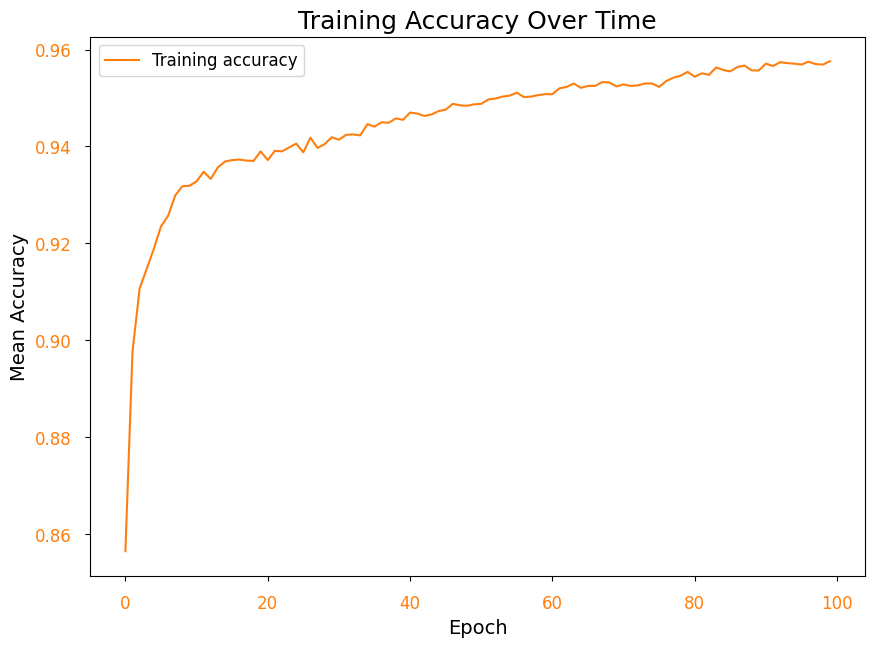

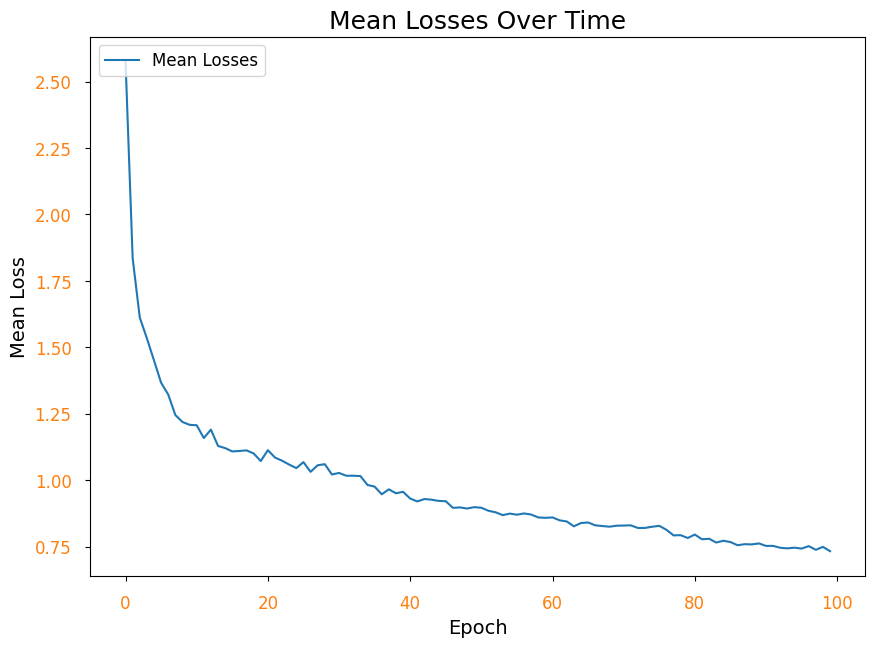

In [7]:
# Set the figure size
plt.figure(figsize=(10, 7))

# Plot the training accuracy
plt.plot(mean_accuracies, color='tab:orange', label='Training accuracy')

# Add a title and axis labels
plt.title('Training Accuracy Over Time', fontsize=18)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Mean Accuracy', fontsize=14)

# Set the font size and style of the tick labels
plt.tick_params(axis='both', which='major', labelsize=12, labelcolor='tab:orange', pad=10)

# Add a legend
plt.legend(loc='upper left', fontsize=12)

# Show the plot
plt.show()

# Set the figure size
plt.figure(figsize=(10, 7))

# Plot the training accuracy
plt.plot(mean_losses, color='tab:blue', label='Mean Losses')

# Add a title and axis labels
plt.title('Mean Losses Over Time', fontsize=18)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Mean Loss', fontsize=14)

# Set the font size and style of the tick labels
plt.tick_params(axis='both', which='major', labelsize=12, labelcolor='tab:orange', pad=10)

# Add a legend
plt.legend(loc='upper left', fontsize=12)

# Show the plot
plt.show()